# orientation-filter

Filter your particles, by how consistent their pose is between runs. 

In [1]:
%matplotlib widget

import starfile

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial import transform
from pathlib import Path

### Inputs

In [4]:
# Insert a list of .star-files describing the outcome of the same Refine3D job
file_list = ["relion/Refine3D/job101/run_data.star",
             "relion/Refine3D/job138/run_data.star",
             "relion/Refine3D/job139/run_data.star"]

### Parsing

In [5]:
# Construct output dataframe
comp_df = pd.DataFrame()
quaternion_list = []
shift_list = []

# Iterate over files, add to comparison dataframe
for i in range(len(file_list)):

    file = Path(file_list[i])    

    print(f"Working on {file.parent.name}")    

    file = starfile.read(file, always_dict=True)
    
    particles = file['particles'].sort_values('rlnImageName')
    
    # Write Particle images to column
    if i == 0:
        comp_df['particle'] = particles['rlnImageName']
        
    # Check that its conserved in any following star-files
    else:
        assert comp_df['particle'].to_list() == particles['rlnImageName'].to_list()
     
    # From the Relion Wiki:
    # "The first rotation is called rlnAngleRot and is around the Z-axis.
    #  The second rotation is called rlnAngleTilt and is around the new Y-axis.
    #  The third rotation is called rlnAnglePsi and is around the new Z axis"
        
    euler_angles = particles[['rlnAngleRot','rlnAngleTilt','rlnAnglePsi']].values
    
    print(f"Euler Angles for first particle are: {euler_angles[0]}")
    
    # Quaternion in w, x, y, z order
    quaternions = transform.Rotation.from_euler("ZYZ", 
                                                euler_angles, 
                                                degrees=True).as_quat(canonical = True,
                                                                      scalar_first = True)
    
    comp_df[f'quaternions_{i}'] = np.split(quaternions, len(particles.index))
    quaternion_list.append(f'quaternions_{i}')
    
    print(f"Quaternions for first particle are: {quaternions[0]}")

    shifts = particles[['rlnOriginXAngst','rlnOriginYAngst']].values
    comp_df[f'shifts_{i}'] = np.split(shifts, len(particles.index))
    shift_list.append(f'shifts_{i}')
    
    print("\n")

Working on job101
Euler Angles for first particle are: [  54.548315  146.192458 -135.16036 ]
Quaternions for first particle are: [ 0.22173762 -0.95336248 -0.08096667 -0.18808725]


Working on job138
Euler Angles for first particle are: [  55.274378  144.505775 -135.53543 ]
Quaternions for first particle are: [ 0.23305587 -0.94817665 -0.08971096 -0.19646358]


Working on job139
Euler Angles for first particle are: [  56.865574  152.32257  -134.75109 ]
Quaternions for first particle are: [ 0.18603553 -0.96598791 -0.0982634  -0.15034111]




### Calculate Statistics

In [6]:
# To calculate stats, stack into ndarray: particles x dimensions x replicates

# Quaternion Stats
quat_array = np.stack([np.concatenate(comp_df[name]) for name in quaternion_list], 
                      axis = -1)
# Get Mean Pose
quat_mean = np.mean(quat_array, axis = 2)

# For each replicate, calculate distance to mean
quat_dist2mean = np.zeros([quat_array.shape[0], quat_array.shape[2]])

for i in range(quat_array.shape[2]):
    quat_dist2mean[:,i] = np.linalg.norm(quat_array[:,:,i] - quat_mean, axis = 1)
quat_meandist_particle = np.mean(quat_dist2mean, axis = 1)
quat_sddist_particle = np.std(quat_dist2mean, axis = 1, ddof = 1)

print(f"The average distances to mean angle for each replicate are: \n"
      f"{np.mean(quat_dist2mean, axis = 0)} \n")

# Origin Stats
xy_array = np.stack([np.concatenate(comp_df[name]) for name in shift_list], 
                     axis = -1)

# Get Mean Shift
xy_mean = np.mean(xy_array, axis = 2)

# For each replicate, calculate distance to mean
xy_dist2mean = np.zeros([xy_array.shape[0], xy_array.shape[2]])

for i in range(quat_array.shape[2]):
    xy_dist2mean[:,i] = np.linalg.norm(xy_array[:,:,i] - xy_mean, axis = 1)
xy_meandist_particle = np.mean(xy_dist2mean, axis = 1)
xy_sddist_particle = np.std(xy_dist2mean, axis = 1, ddof = 1)

print(f"The shift for each replicate vs. mean are: \n"
      f"{np.mean(xy_dist2mean, axis = 0)} \n"
      "Maybe exclude any obvious outliers? \n")

The average distances to mean angle for each replicate are: 
[0.19248612 0.21780665 0.21846777] 

The shift for each replicate vs. mean are: 
[1.16519263 1.31978745 1.3072807 ] 
Maybe exclude any obvious outliers? 



### Plot Input Data

In [7]:
# Create random subset of particles to show (to make plotting faster)
plot_1k_idx = np.sort(np.random.randint(0, len(comp_df.index) -1, size = (1000)))
plot_10k_idx = np.sort(np.random.randint(0, len(comp_df.index) -1, size = (10000)))

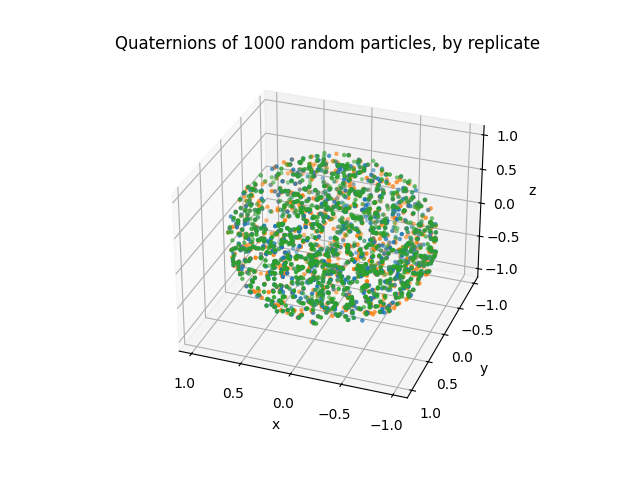

In [8]:
# Plot Quaternions (first 1000 particles)

fig1 = plt.figure()
ax = fig1.add_subplot(projection='3d')

for i in range(quat_array.shape[2]):

    ax.scatter(quat_array[plot_1k_idx,1,i],
               quat_array[plot_1k_idx,2,i],
               quat_array[plot_1k_idx,3,i],
               marker = '.',)


ax.view_init(30, 110, 0)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.set_title("Quaternions of 1000 random particles, by replicate")

plt.show()

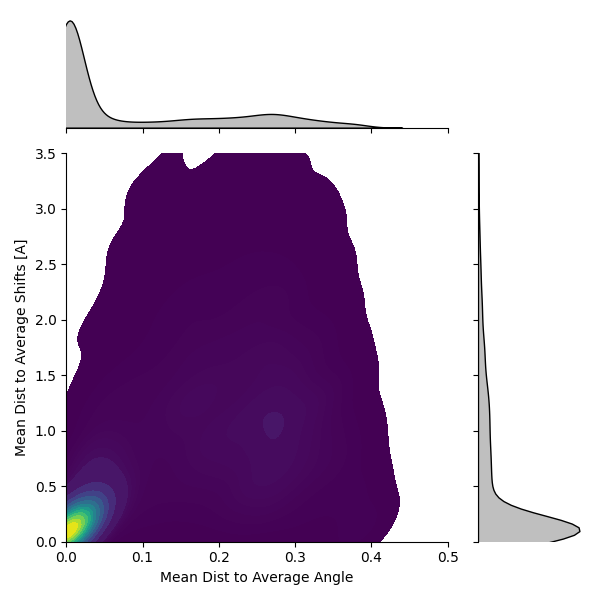

In [13]:
plt.close()

# Distribution of Variances (Random 10k)

fig2 = sns.jointplot(x=quat_sddist_particle[plot_10k_idx],
                   y=xy_sddist_particle[plot_10k_idx],
                   kind='kde',
                   ratio = 3,
                   fill = True,
                   color = 'black',
                   cmap = 'viridis',
                   levels = 20,
                   thresh = .01,
                   xlim = (0,0.5),
                   ylim = (0,3.5))
fig2.set_axis_labels(xlabel = "Mean Dist to Average Angle",
                    ylabel = "Mean Dist to Average Shifts [A]")

plt.tight_layout()

### Set Thresholds and Filter

In [75]:
# Maximum per-particle SD for xy offsets and quaternions (vs. per-particle mean)
xy_thresh = 0.25
quat_thresh = 0.03

# Make mask for Dataframe
keep_mask = (quat_sddist_particle < quat_thresh) & (xy_sddist_particle < xy_thresh)

# Construct Output Dataframe
filtered_df = {}
filtered_df['optics'] = file['optics']
filtered_df['particles'] = file['particles'].sort_values('rlnImageName')

# Make sure we still have the right order
assert filtered_df['particles']['rlnImageName'].to_list() == comp_df['particle'].to_list()

# Put in the mean euler angles, and the mean shift
filtered_df['particles']['rlnOriginXAngst'] = xy_mean[:,0]
filtered_df['particles']['rlnOriginXAngst'] = xy_mean[:,1]

euler_angles_mean = transform.Rotation.from_quat(quat_mean, 
                                                 scalar_first=True).as_euler("ZYZ", 
                                                                             degrees = True)

filtered_df['particles']['rlnAngleRot'] = np.split(euler_angles_mean,3,axis=1)[0]
filtered_df['particles']['rlnAngleTilt'] = np.split(euler_angles_mean,3,axis=1)[1]
filtered_df['particles']['rlnAnglePsi'] = np.split(euler_angles_mean,3,axis=1)[2]

# Filter by thresholds above
filtered_df['particles'] = file['particles'][keep_mask]

print(f"Kept {len(filtered_df['particles'].index)} of {len(comp_df.index)} particles.")

# Write out .star file
starfile.write(filtered_df, "particles_filtered.star")
print("Writing filtered starfile to particles_filtered.star")

Kept 376575 of 656224 particles.
Writing filtered starfile to particles_filtered.star


### Diagnostic Plots

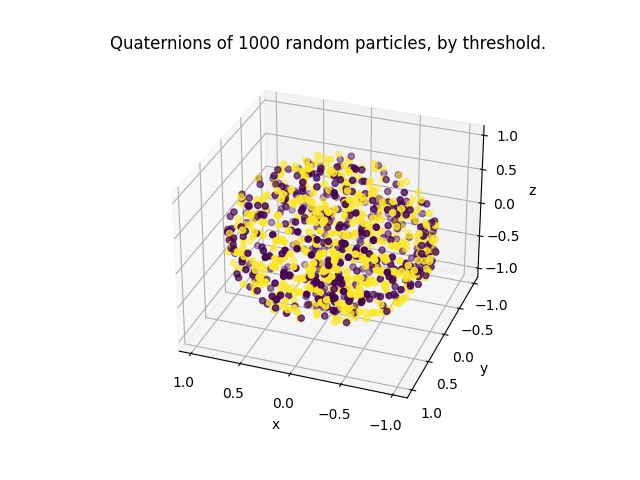

In [130]:
# Plot distribution of particles on sphere by true
fig3 = plt.figure()
ax = fig3.add_subplot(projection='3d')

ax.scatter(quaternions[plot_1k_idx,1],
           quaternions[plot_1k_idx,2],
           quaternions[plot_1k_idx,3],
           c = keep_mask[plot_1k_idx],
           marker = 'o',)

ax.view_init(30, 110, 0)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.set_title("Quaternions of 1000 random particles, by threshold.")

plt.show()